In [5]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', 'latitude', 'longitude',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target']

df = data[selected_columns]
df.head()

,id,아파트명,전용면적(㎡),계약년월,계약일,층,구,동,latitude,longitude,...,closest_subway_station_distance,bus_stop_count_500m,subway_station_count_500m,bus_stop_count_750m,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target
0,0,개포6차우성,79.97,2017-12-01,8,3,강남구,개포동,37.476283,127.056841,...,1187.188361,12,0,38,0,57,0,6.609733,0,124000.0
1,1,개포6차우성,79.97,2017-12-01,22,4,강남구,개포동,37.476283,127.056841,...,1187.188361,12,0,38,0,57,0,6.609733,0,123500.0
2,2,개포6차우성,54.98,2017-12-01,28,5,강남구,개포동,37.476283,127.056841,...,1187.188361,12,0,38,0,57,0,6.609733,0,91500.0
3,3,개포6차우성,79.97,2018-01-01,3,4,강남구,개포동,37.476283,127.056841,...,1187.188361,12,0,38,0,57,0,6.609733,0,130000.0
4,4,개포6차우성,79.97,2018-01-01,8,2,강남구,개포동,37.476283,127.056841,...,1187.188361,12,0,38,0,57,0,6.609733,0,117000.0


In [6]:
df['지역'] = df.apply(lambda x: x['구']+' '+ x['동'], axis=1)
df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

regions = list(df['지역'].unique())


In [7]:
df['구'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

<Axes: xlabel='latitude', ylabel='target'>

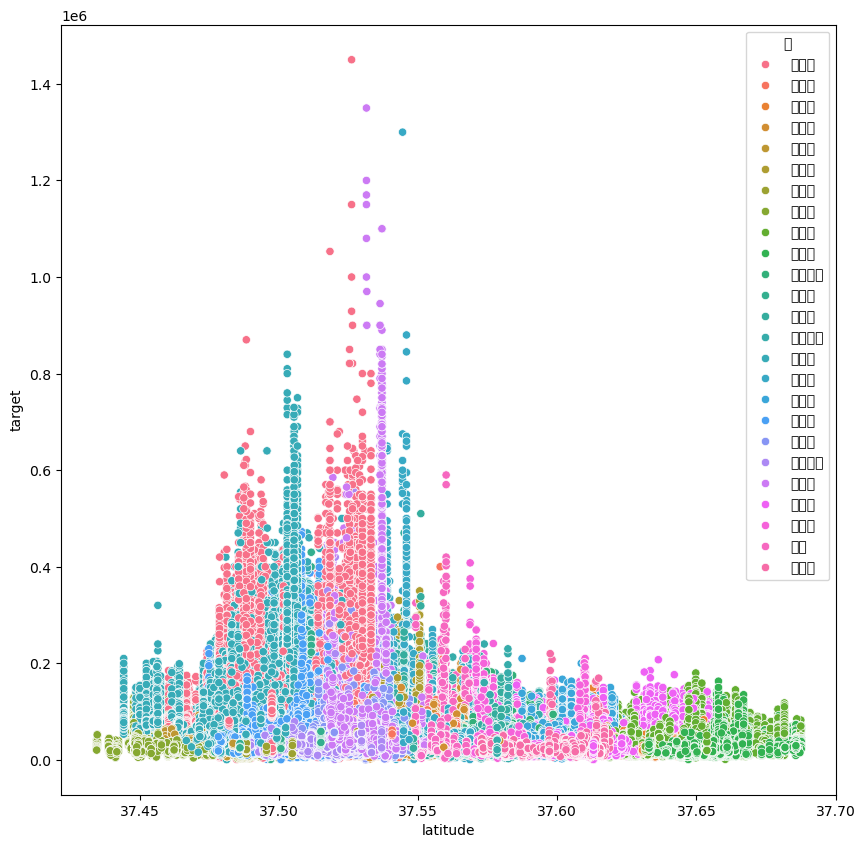

In [17]:
import seaborn as sns

train_df = df.query("is_test == 0")

plt.figure(figsize=(10, 10))
sns.scatterplot(data=train_df, x = 'latitude', y='target', hue='구')